# Applications of Convolutional Neural Networks.

## **Object Detection and Localization**

### Theory

Object detection involves identifying the presence of objects within an image and accurately localizing them by constructing bounding boxes assigned to their spatial location. This task is essential for various computer vision applications, including autonomous driving, surveillance, and image understanding.

Object detection in computer vision can be achieved through two foundational approaches: 
- **two-stage** detection: (1) generation of region proposals ; (2) refinement of region proposals and classification
- **one-stage** detection: (1) + (2) in a single forward pass




One of the most popular two-stage approaches are [YOLO](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf) and [SSD](https://arxiv.org/pdf/1512.02325.pdf"source"), both working on *grid-like* structures of the input image. That is, the image is partitioned into a grid of cells, of arbitrary dimension (or multiple grids at different scales, in the case of SSD), with an object being attributed to cell if it's center coordinates fall into the area it occupies in the image.

Since multiple objects can overlap to some extent, while being attributed to the same grid cell, a set of  **anchor boxes** are considered to each cell, each with a different aspect ratio. Anchor boxes are chosen through exploration of the training data, choosing corresponding height/width ratios that represent the different objects. Therefore, each grid cell predicts multiple bounding boxes that can be attributed to partially overlapping objects with different aspect ratios.

Given a $S\times S$ grid, a list of $N$ ground-truth bounding boxes $B = \{(x, y, w, h)_i\}_{i=1}^N$ with associated classes $C=\{c_i\}_{i=1}^N$, the output tensor $Y$ can be defined in the following manner:

$$Y: \, (S, S, |\mathcal{A}|, 5 + \text{\#classes})$$ 
$$Y[i, j]: \, (p_{ij}, x, y, w, h, \underbrace{0, 0, \dots, 1, \dots, 0}_{\text{one-hot class coding}}), \, \forall (i, j) \in \{1, \dots, S\}^2, \, b \in \{1, \dots, |\mathcal{A}|\}$$

where
- $\mathcal{A}$ represents the set of allowable anchor boxes for each cell
- $Y[i, j]$ is the vector label associated to the anchor box $j$ of a grid cell $i$
- $p_{ij}$ is the probability that in the cell $i$ there is an object with dimensions similar to the anchor box $j$ (1 or 0 for ground truth)

Thus, an object detector system should be able to produce an output similar to $Y$, which is further post-processed by thresholding the predicted object probabilities (filtering out the predictions below it) and imposing certain restrictions on the overlap between bounding boxes (see below the **Non-Maximum Suppression** algorithm).

To perform only localization (no classification) the one-hot vector can be dropped from the label encoding.

<div style="text-align: center;">
  <img src="imgs/grid.png" alt="description" width="800"/>
  <figcaption><a href=https://learn.microsoft.com/en-us/dotnet/machine-learning/tutorials/media/object-detection-onnx/model-output-description.png>Source</a></figcaption>
</div>

<ins>Note:</ins> It's a custom for a bounding box $(x, y, w, h)$ to be expressed relative to the position of its assigned grid cell. E.g. $(x, y) = (0, 0.1)$ and $(w, h) = (1.1, 0.3)$ corresponds to a bounding box with $y$-position displaced by $0.1 \times \text{cell\_size}$ from it's upper-left corner, with a width equal to $1.1\times \text{cell\_size}$ and a height of $0.3\times \text{cell\_size}$.

### The cost function

The original YOLO is optimized through the following loss:

$$\mathcal{L} = \lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^{|\mathcal{A}|} 1_{i j}^{o b j}\left[ \underbrace{\left(x_i-\hat{x}_i\right)^2+\left(y_i-\hat{y}_i\right)^2}_{\text{localization error}}\right ] + \newline \lambda_{\text {coord }} \sum_{i=0}^{S^2} \sum_{j=0}^{|\mathcal{A}|} 1_{i j}^{o b j}\left[\underbrace{\left(\sqrt{w_i}-\sqrt{\hat{w}_i}\right)^2+\left(\sqrt{h_i}-\sqrt{\hat{h}_i}\right)^2}_{\text{bounding box dimension error}}\right] + \newline \sum_{i=0}^{S^2} \sum_{j=0}^{|\mathcal{A}|} \underbrace{1_{i j}^{o b j}\left(C_{ij}-\hat{C_{ij}}\right)^2}_{\text{object cell probability error}} + \newline \lambda_{\text {noobj }} \sum_{i=0}^{S^2} \sum_{j=0}^{|\mathcal{A}|} \underbrace{1_{i j}^{n o o b j}\left(C_{ij}-\hat{C_{ij}}\right)^2}_{\text{empty cell probability error}} + \newline \sum_{i=0}^{S^2} \sum_{j=0}^{|\mathcal{A}|} 1_{ij}^{o b j} \sum_{c \in \text { classes }}\underbrace{\left(p_{ij}(c)-\hat{p}_{ij}(c)\right)^2}_{\text{classification error}}$$

where:
- $1_{ij}^{o b j}$, $1_{ij}^{n o o b j}$ are indicator functions, taking the value 1 if in the $i^{th}$ cell and $j^{th}$ bounding box there is/there isn't an object, and 0 otherwise
- $\lambda_{coord}$, $\lambda_{noobj}$ are weighting factors of different loss components
- $p_{ij}(c)$, $\hat{p_{ij}}(c)$
- $C_{ij}$, $\hat{C_{ij}}$ represent *objectness* scores of anchor $j$ in cell $i$, where $C_{ij} = p_{ij}$ and $C_{ij} = \hat{p_{ij}} * IoU(\text{predicted, ground-truth})$

The square root is applied over the ground-truth/predicted width and height to counteract the strong effect of larger bounding boxes over smaller ones. Although it seems strange to apply squared error over probability differences (compared to the cross-entropy we've used in `Lab#1` and `Lab#2`), this choice is supported by the fact that the global loss is easier to optimize -- using $\ell_2$ loss everywhere maintains some form of stability.

[YOLOv7](https://openaccess.thecvf.com/content/CVPR2023/html/Wang_YOLOv7_Trainable_Bag-of-Freebies_Sets_New_State-of-the-Art_for_Real-Time_Object_Detectors_CVPR_2023_paper.html) uses a [*Complete IoU*](https://karthikziffer.github.io/journal/Complete-IoU.html) loss as a replacement for the localization and bounding box dimension errors, along with other [improvements](https://learnopencv.com/yolo-loss-function-siou-focal-loss/#aioseo-yolo-loss-functions:~:text=softmax%20activation%20etc.-,YOLO%20Loss%20Functions,-Loss%20functions%20in). 

The new [YOLOv11](https://docs.ultralytics.com/models/yolo11/) offers increased performance across several benchmark, compared to its predecessors.

## Use-case: Traffic Sign Localization and Recognition

### Data Preparation

We'll be using the [Kaggle API](https://www.kaggle.com/docs/api) to download the data. To do so, you'll need to follow [these instructions](https://www.kaggle.com/docs/api). Alternatively, once you have a Kaggle account, you can manually download it from [here](https://www.kaggle.com/datasets/ahemateja19bec1025/trafficsignlocalizationdetectionyoloannotated) (`Download` $\rightarrow$ `Download dataset as zip`)

In [ ]:
!pip install kaggle
!kaggle datasets download -d ahemateja19bec1025/trafficsignlocalizationdetectionyoloannotated -p ./data

Once you downloaded the `.zip` and placed it in your `./data` folder, run the following cell to extract its contents. 

In [6]:
import zipfile
with zipfile.ZipFile("./data/trafficsignlocalizationdetectionyoloannotated.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/traffic_signs/")

In [7]:
train_files_path = "./data/traffic_signs/TrafficSignLocalizationandDetection/train/"
val_files_path = "./data/traffic_signs/TrafficSignLocalizationandDetection/valid/"
test_files_path = "./data/traffic_signs/TrafficSignLocalizationandDetection/test/"

The following cell contains the custom `Dataset` class which returns images and associated labels -- and `object_map`, which contains 1 wherever there is an object; and a `coords_map`, which contains at each anchor, where there is an object, the relative coordinates of that object.

In [8]:
import os
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, n_cells=9, im_size=None, only_boxes=True):
        """
        :param root_dir: string, folder containing sub-folders 'images' and 'labels'
        :param only_boxes: bool, whether the output is given only by the boxes (localization) or contains the sign class (localization + recognition)
        :param n_cells: int, the image is split into n_cells x n_cells 

        In order to not use multiple anchors, we'll enlarge each bounding box to a square form, and take as the only anchor a square shape.
        
        The output will be a dictionary containing the following:
            "box_confidence": array of shape (n_cells, n_cells, 1) - the probability for an object to be in a cell, in the form of an anchor 
            "box_coordinates": array of shape (n_cells, n_cells, 4) - midpoint and dimension for each anchor box in a cell
        """
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.label_files = [f for f in os.listdir(self.label_dir) if f.endswith('.txt')]
        self.n_cells = n_cells
        self.im_size = im_size
        
        self.only_boxes = only_boxes

    def __len__(self):
        return len(self.image_files)

    def get_full_image_boxes(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        label_name = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + '.txt')
        image = Image.open(img_name).convert('RGB')
        if self.im_size:
            image = image.resize(self.im_size)
        image = np.array(image) / 255.0

        with open(label_name, 'r') as f:
            lines = f.readlines()

        boxes = []
        for line in lines:
            data = line.strip().split()
            class_id = int(data[0]) 
            
            x_center, y_center, width, height = map(float, data[1:])
            # make the bounding box square
            width, height = max(width, height), max(width, height)
            
            if self.only_boxes:
                boxes.append([x_center, y_center, width, height])
            else:
                boxes.append([x_center, y_center, width, height, class_id])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        return torch.Tensor(image), torch.Tensor(boxes)

    def construct_object_map(self, boxes, width, height):
        """
        Returns a n_cells x n_cells grid with 1 where there is an overlapping bounding box, and 0 otherwise.
        """
        output_map = np.zeros((self.n_cells, self.n_cells))
    
        for box in boxes:
            x, y, w, h = box
    
            center_x = int(x * self.n_cells)
            center_y = int(y * self.n_cells)
    
            output_map[center_y, center_x] = 1
    
        return output_map

    def construct_cell_coordinates(self, boxes, width, height):
        """
        Returns a n_cells x n_cells x 4 grid containing the coordinate for each 
        """
        output_coords = np.zeros((self.n_cells, self.n_cells, 4))

        cell_width, cell_height = width / self.n_cells, height / self.n_cells
        
        for box in boxes:
            x, y, w, h = box
            
            cell_x = int(x * self.n_cells)
            cell_y = int(y * self.n_cells)
            
            tx = x * self.n_cells - cell_x
            ty = y * self.n_cells - cell_y
            tw = w * width / cell_width
            th = h * height / cell_height
            
            output_coords[cell_y, cell_x] = np.array([tx, ty, tw, th])
            
        return torch.Tensor(output_coords).permute(2, 0, 1)
    
    def __getitem__(self, idx):
        """
        Returns the image and a dictionary containing the two tensors used as label.
        """
        image, boxes,  = self.get_full_image_boxes(idx)

        object_map = self.construct_object_map(boxes, image.shape[1], image.shape[0])
        coords_map = self.construct_cell_coordinates(boxes, image.shape[1], image.shape[0])
        
        label = torch.cat((torch.Tensor(object_map[None, ...]), coords_map), dim=0)
        
        return image.permute(2, 0, 1), label
    
    def plot_image_with_boxes(self, idx):
        image, boxes = self.get_full_image_boxes(idx)
        image, boxes = image.numpy(), boxes.numpy()

        output_map = self.construct_object_map(boxes, image.shape[1], image.shape[0])

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        axes[0].set_title("Real Image w/ Bounding Box")
        axes[0].imshow(image)

        coords = []
        for box in boxes:
            if self.only_boxes:
                x_center, y_center, width, height = box
            else:
                x_center, y_center, width, height, _ = box
            x1 = (x_center - width / 2) * image.shape[1]
            y1 = (y_center - height / 2) * image.shape[0]
            x2 = (x_center + width / 2) * image.shape[1]
            y2 = (y_center + height / 2) * image.shape[0]
            box_width = x2 - x1
            box_height = y2 - y1
            bbox = Rectangle(
                (x1, y1), box_width, box_height, fill=False, edgecolor='red', linewidth=2
            )
            axes[0].add_patch(bbox)

            coords.append((x1, y1, box_width, box_height))

        axes[0].axis('off')

        axes[1].set_title("Corresponding Grid Cell")
        axes[1].imshow(output_map, cmap='binary', interpolation='nearest', extent=[0, self.n_cells, 0, self.n_cells])
        axes[1].set_xticks(list(range(1, self.n_cells+1)), labels=list(range(1, self.n_cells+1)), rotation='vertical')
        axes[1].set_yticks(list(range(1, self.n_cells+1)))
        axes[1].grid(which='both', color='gray', linestyle='-', linewidth=1)
        for x, y, w, h in coords:
            x *= self.n_cells / image.shape[1]
            y *= self.n_cells / image.shape[0]
            w *= self.n_cells / image.shape[1]
            h *= self.n_cells / image.shape[0]

            y = self.n_cells - y - h  # reversed y-axis
            
            bbox = Rectangle(
                (x, y), w, h, fill=False, edgecolor='red', linewidth=2
            )
            circle = Circle((x + w / 2, y + h / 2), radius=0.1, fill=True, ec="red", fc="red", linewidth=0.01)
            
            axes[1].add_patch(bbox)
            axes[1].add_patch(circle)
            
        plt.show()

In [9]:
n_cells = 19
im_size = (256, 256)

train_dataset = CustomDataset(train_files_path, n_cells=n_cells, im_size=im_size)
val_dataset = CustomDataset(val_files_path, n_cells=n_cells, im_size=im_size)
test_dataset = CustomDataset(test_files_path, n_cells=n_cells, im_size=im_size)

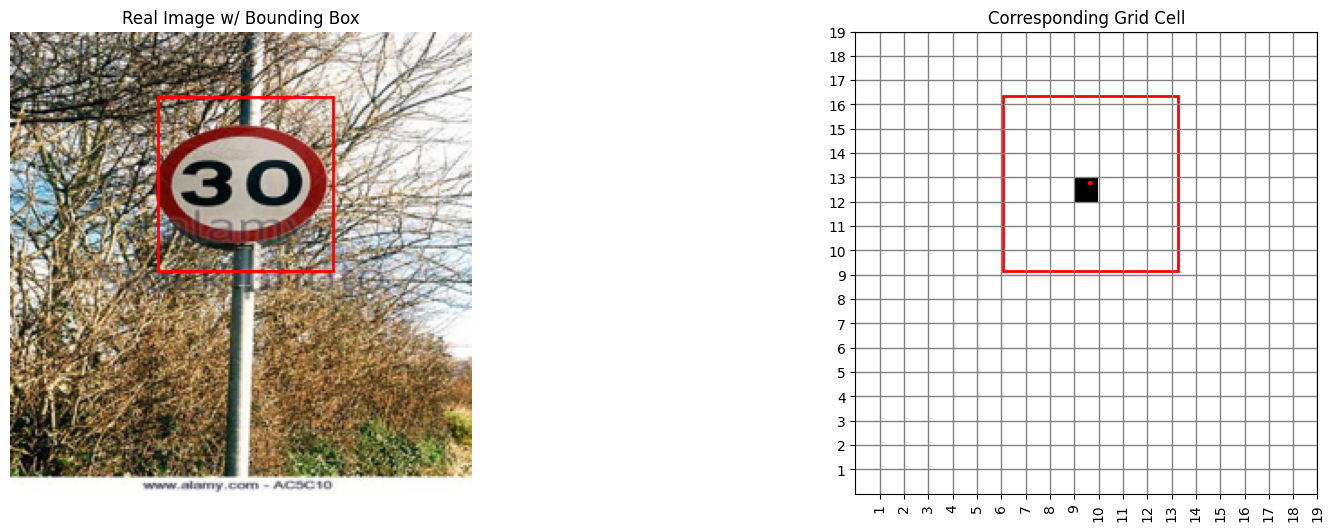

In [38]:
i = np.random.randint(len(train_dataset))
train_dataset.plot_image_with_boxes(i)
image, label = train_dataset[i]

In [17]:
print(label.shape)
print("Number of objects: ", label[0].sum())
print("Object coordinates (relative): \n", label[1:, label[0] > 0].permute(1, 0).numpy())

torch.Size([5, 19, 19])
Number of objects:  tensor(2.)
Object coordinates (relative): 
 [[0.7043271  0.43629837 0.57091343 0.57091343]
 [0.5637016  0.07572174 0.45673078 0.45673078]]


For this simplified version, the output is formed by concatenating two tensors:
- Per-cell object confidence: $(1, n_{\text{cells}}, n_{\text{cells}})$
- Per-cell object coordinates: $(4, n_{\text{cells}}, n_{\text{cells}})$

This encoding assumes that all bounding boxes are of the same shape (square) and that there is only one possible object per grid cell.

For a complete approach to object localization, you can take a look at [Yolo v3 Pytorch tutorial](https://www.kaggle.com/code/arunmohan003/yolo-v3-pytorch-tutorial-from-scratch). 

### Simplified Loss Function

For the chosen approach, our loss function should be able to:
- measure the error for object assignment to different grid cells
- measure the error for bounding box coordinates, on the cells which contain objects 

In [19]:
import torch.nn as nn

class LocalizationLoss(nn.Module):
    def __init__(self, obj_weight=1, coord_weight=1, positive_weight=1):
        """
        Simplified YOLO loss.

        :param obj_weight: float, weight factor for object identification
        :param coord_weight: float, weight factor for object localization
        :param positive_weight: float, weight of positive samples - i.e. how much more important are object cells than non-object cells
        """
        super().__init__()
        
        self.assign_error = nn.BCEWithLogitsLoss(reduction="mean", pos_weight=torch.tensor(positive_weight).float())  # works better than origina YOLO L2 loss
        self.coord_error = nn.MSELoss(reduction="mean")

        self.obj_weight = obj_weight
        self.coord_weight = coord_weight
    
    def forward(self, predicted, target):
        """
        Computes BCE for object presence and MSE for object localization.
        BCE expects unnormalized logits (no Sigmoid before) - tries to make non-object cells as negative as possible: Sigmoid(logit) -> 0

        :param target: torch.Tensor of shape (batch, 5, n_cells, n_cells), with target[:, 0] representing the per-cell object confidence, and target[:, 1:] the coordinates
        :param predicted: same
        """
        
        assign_loss = self.assign_error(
            predicted[:, 0].view(predicted.shape[0], -1), 
            target[:, 0].view(predicted.shape[0], -1)
        )
        
        # MSE needs to be taken only for the cells that contain objects
        _predicted = predicted[:, 1:] * (target[:, 0].unsqueeze(1) > 0)
        coord_loss_xy = self.coord_error(_predicted[:, 0:2], target[:, 1:3])
        coord_loss_hw = self.coord_error(torch.sqrt(_predicted[:, 2:] + 1e-7), torch.sqrt(target[:, 3:] + 1e-7))
        
        return self.coord_weight * (coord_loss_xy + coord_loss_hw) + self.obj_weight * assign_loss

Since we are dealing with a lot of negative examples (empty cells) and very few positive samples (object cells), we can assign a higher weight to the error related to positive samples to counteract the high influence of easy negative samples on the final loss. 

For an example $x_i$ of class $y_i \in \{0, 1\}$ ($y_i$ encodes the existence/non-existence of an object) and predicted logit value $\hat{y_i}$, the positively weighted binary-crossentropy loss is defined as:
$$\text{wBCE}(y_i, \hat{y_i}) = - w_p [\, y_i \, log(\sigma(\hat{y_i})) - (1 - y_i) \, log (1 - \sigma(\hat{y_i}))]$$
where $\sigma(\cdot)$ denotes the *Sigmoid* activation. In our case, for a completely balanced BCE error, we could choose: $$w_p = \frac{\text{\# non-object cells}}{\text{\# object cells}}$$

You should check out [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss) class, for a complete list of its parameters.

In [20]:
loc_loss = LocalizationLoss(positive_weight=(n_cells * n_cells) / 2)

loc_loss(label[None, ...], label[None, ...])

tensor(1.0026)

Although the ground-truth we passed as the `predicted` argument, the loss is not 0 since **BCE expects the prediction to be formed by logits**, not probabilities.


### Define Localization Model using a pre-trained Backbone

Similar to the `Transfer Learning` technique we discussed in `Lab#2`, we can use a pre-trained vision model to do most of our work, and then learn the mapping between its high-level features and our object detection probabilities and coordinates.

In [21]:
from torchvision.models import squeezenet1_0
from torchvision.transforms import Resize


class ObjectDetectionModel(nn.Module):
    def __init__(self, n_cells, hw=(256, 256)):
        super(ObjectDetectionModel, self).__init__()
    
        self.n_cells = n_cells
        self.hw = hw
        
        # Use the features of a pre-trained model (backbone)
        self.backbone = squeezenet1_0(pretrained=True).features

        for param in self.backbone.parameters():
            param.requires_grad = False
        
        self.out_ch = None
        self.out_h = None
        self.out_w = None
        self._get_backbone_out_shape()

        self.resize_features = Resize((self.n_cells, self.n_cells))
        
        # Separate heads for the two outputs
        # You can try using a single head for both tasks, by appropriately choosing the output channels!
        self.assignment_head = nn.Sequential(
            nn.Conv2d(self.out_ch, 16, kernel_size=1, padding=0),
            nn.Dropout(p=0.3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1, padding=0),
        )

        self.coordinates_head = nn.Sequential(
            nn.Conv2d(self.out_ch, 16, kernel_size=1, padding=0),
            nn.Dropout(p=0.3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, kernel_size=1, padding=0),
            nn.ReLU(),
        )

    def _get_backbone_out_shape(self):
        _, self.out_ch, self.out_h, self.out_w = self.backbone(torch.rand(1, 3, self.hw[0], self.hw[1])).shape

    def forward(self, x):
        features = self.backbone(x)
        features = self.resize_features(features)

        assigns = self.assignment_head(features)
        coords = self.coordinates_head(features)
        
        output = torch.cat((assigns, coords), dim=1)
        return output
        

In [22]:
from torchsummary import summary

summary(ObjectDetectionModel(n_cells), (3, im_size[0], im_size[1]), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 125, 125]          14,208
              ReLU-2         [-1, 96, 125, 125]               0
         MaxPool2d-3           [-1, 96, 62, 62]               0
            Conv2d-4           [-1, 16, 62, 62]           1,552
              ReLU-5           [-1, 16, 62, 62]               0
            Conv2d-6           [-1, 64, 62, 62]           1,088
              ReLU-7           [-1, 64, 62, 62]               0
            Conv2d-8           [-1, 64, 62, 62]           9,280
              ReLU-9           [-1, 64, 62, 62]               0
             Fire-10          [-1, 128, 62, 62]               0
           Conv2d-11           [-1, 16, 62, 62]           2,064
             ReLU-12           [-1, 16, 62, 62]               0
           Conv2d-13           [-1, 64, 62, 62]           1,088
             ReLU-14           [-1, 64,

/opt/anaconda3/envs/ia2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ia2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/envs/ia2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this

Check out PyTorch's pre-trained models for [Object Detection](https://pytorch.org/vision/0.8/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

### Define hyperparameters and train

$\text{L}_2$ regularization, also known as weight decay, is a technique used in training neural networks to prevent overfitting by penalizing large weight values. It adds a regularization term to the loss function, which depends on the magnitude of the weight matrices $W_i$:
$$\mathcal{L} \leftarrow \mathcal{L} + \frac{\lambda}{2} \sum_{i=0}^m ||\widehat{W_i}||_2^2$$
where $m$ is the number of layers, $\widehat{W_i}$ is a vectorized version of weight matrix $W_i$, and $||\cdot||_2$ is the $\text{L}_2$ norm: i.e. for a vector $\textbf{u} = (u_1, \dots, u_N) \in \mathbb{R}^N$, $||\textbf{u}||_2 = \sqrt{\sum_{i=1}^N u_i^2}$. Thus, the optimization problem is modified such that large squared weight values are penalized.

In [41]:
batch_size = 32
epochs = 5
lr = 1e-3
l2_penalty = 1e-3
print_frequency = 1

obj_weight = 2
coord_weight = 1
pos_weight = 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using {device}.")

model = ObjectDetectionModel(n_cells)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_penalty)
criterion = LocalizationLoss(obj_weight, coord_weight, pos_weight)

Using cpu.


/opt/anaconda3/envs/ia2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ia2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
import torch_utils
import importlib
importlib.reload(torch_utils)

# Define root folder and file_name for saving
folder_path = "models/localization"
file_name = "model.pth"

train_losses, test_losses = torch_utils.train_loop(
                                                    model, 
                                                    train_loader=train_dataloader, 
                                                    optimizer=optimizer, 
                                                    loss=criterion, 
                                                    epochs=epochs, 
                                                    test_loader=val_dataloader, 
                                                    device=device, 
                                                    folder_path=folder_path, 
                                                    file_name=file_name,
                                                    print_frequency=print_frequency
                                                  )

100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Train loss improved from inf to 0.09412053261290897. Overwriting...
Epoch 1/5: train_loss=0.09412053261290897 test_loss=0.12691651533047357


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]


Train loss improved from 0.09412053261290897 to 0.08626481568948789. Overwriting...
Epoch 2/5: train_loss=0.08626481568948789 test_loss=0.11356223250428836


100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Train loss improved from 0.08626481568948789 to 0.08024381321262229. Overwriting...
Epoch 3/5: train_loss=0.08024381321262229 test_loss=0.10341368367274602


100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Train loss improved from 0.08024381321262229 to 0.07517546499994668. Overwriting...
Epoch 4/5: train_loss=0.07517546499994668 test_loss=0.09782266244292259


100%|██████████| 6/6 [00:08<00:00,  1.46s/it]

Train loss improved from 0.07517546499994668 to 0.07164608229967681. Overwriting...
Epoch 5/5: train_loss=0.07164608229967681 test_loss=0.08330609649419785


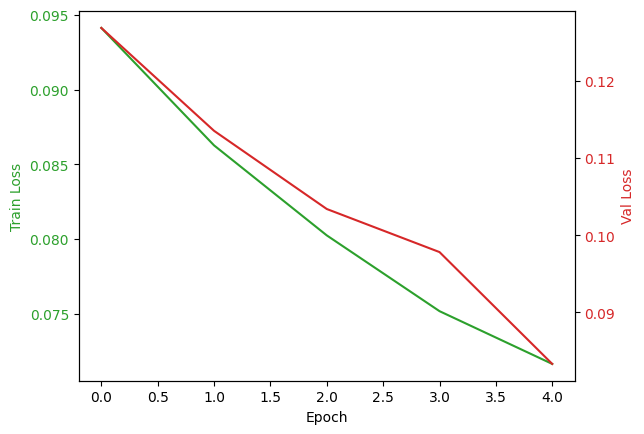

In [57]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis on the right side
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Val Loss', color=color)
ax2.plot(test_losses, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.show()

### **Non-Maximum Suppresion**

Non-maximum suppression (NMS) is a technique used in object detection to eliminate redundant overlapping bounding boxes. An IoU (Intersection over Union) threshold is applied to determine how much overlap between bounding boxes is acceptable. 

The NMS algorithm works as follows:


***
**Inputs**: 
- a list of predicted bounding boxes $\text{B} = \{(x_i, y_i, w_i, h_i)\}_{i=1}^N$; 
- a list of predicted confidence values $\text{C} = \{c_i\}_{i=1}^N$ ; 
- an IoU threshold $\tau$ ;
***
1. Initialize empty list of output bounding boxes $\text{D} \leftarrow \{\}$ ;<br>
2. Get the box with highest score: $b_{max} \leftarrow \text{B}[argmax_k \, c_k]$ ;<br>
3. $\text{B} \leftarrow \text{B} - \{b_{max}\}$; $\text{D} \leftarrow \text{D} \, \cup \, \{b_{max}\}$ ;<br>
4. Iterate over $\text{B}$ and compute IoU scores $\text{IoUs} \leftarrow \{\text{IoU}(b_{max}, b_k)\}_{k=1}^{|B|}$ ;<br>
5. Create a list of bounding box indices for which the threshold $\tau$ is surpassed $\text{I} = \{k \in \{1, \dots, |B|\} \,|\, \text{IoUs[k]} \geq \tau\}$ ;<br>
6. Remove the boxes with indices $\text{I}$ from $\text{B}$ ;<br>
7. Repeat Step 2 while $B \neq \emptyset$ ;
***

In [58]:
def iou_boxes(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[0] + bbox1[2], bbox2[0] + bbox2[2])
    y2 = min(bbox1[1] + bbox1[3], bbox2[1] + bbox2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    bbox1_area = bbox1[2] * bbox1[3]
    bbox2_area = bbox2[2] * bbox2[3]

    union_area = bbox1_area + bbox2_area - intersection_area

    iou = intersection_area / float(union_area + 1e-7)

    return iou

def non_max_suppression(bboxes, confidences, iou_th):
    """
    Non-Maximum Suppresion over predicted bounding boxes.

    :param bboxes: list of tuples (x, y, w, h) where (x, y) are the lower-left corner coordinates and (w, h) the bbox dimensions (in pixels)\
    :param confidences: list of predicted probabilities for each bbox
    :param iou_th: 
    """

    bboxes_with_confidences = list(zip(bboxes, confidences))
    bboxes_with_confidences.sort(key=lambda x: x[1], reverse=True)

    selected_bboxes = []

    while len(bboxes_with_confidences) > 0:
        max_bbox, max_confidence = bboxes_with_confidences.pop(0)

        selected_bboxes.append(max_bbox)

        overlapping_indices = []

        for i, (bbox, _) in enumerate(bboxes_with_confidences):
            iou = iou_boxes(max_bbox, bbox)
            if iou > iou_th:
                overlapping_indices.append(i)

        for index in sorted(overlapping_indices, reverse=True):
            del bboxes_with_confidences[index]

    return selected_bboxes

In [59]:
iou_boxes(
    (10, 10, 10, 10),
    (15, 15, 5, 5)
)

0.24999999975

Below, a functionality for plotting is defined, by:
1. Filtering predictions with a confidence lower than `confidence_threshold`
2. If `use_nms == True`, these will further be filtered using the NMS algorithm discussed above, using an `iou_threshold` to remove redundant bounding boxes.

In [77]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_image_bb(image, label, pred, n_cells, confidence_threshold=0.5, use_nms=False, iou_threshold=0.5, plot=True):
    """
    Plots the image with ground-truth and predicted bounding boxes.

    :param image: torch.Tensor of shape (3, H, W)
    :param label: torch.Tensor of shape (5, n_cells, n_cells)
    :param prediction: torch.Tensor of shape (5, n_cells, n_cells) containing raw output values
    :param n_cells: int, number of grid cells the image is divided into
    :param threshold: float, [0, 1] value above which an object is considered to be part of a cell
    :param plot: bool, if True then plot prediction bboxes. If False, return some numerical performance
    """
    prediction = pred.cpu().detach().clone()
    prediction[0] = nn.Sigmoid()(prediction[0])
    
    true_rectangles = []
    pred_rectangles = []
    confidences = []
    
    cell_w, cell_h = image.shape[2] / n_cells, image.shape[1] / n_cells

    # Compute some metrics
    n_correct = 0
    n_total = 0
    for i in range(n_cells):
        for j in range(n_cells):
            is_obj = False
            
            if label[0, i, j] == 1:
                is_obj = True
                n_total += 1
                
                x, y, w, h = label[1:, i, j]
                
                w, h = w * cell_w, h * cell_h
                x = ((x + j) / n_cells) * image.shape[2]
                y = ((y + i) / n_cells) * image.shape[1]
                x, y = x - w / 2, y - h / 2
                    
                true_rectangles.append((x, y, w, h))
            
            if prediction[0, i, j] >= confidence_threshold:
                x, y, w, h = prediction[1:, i, j]
                
                w, h = w * cell_w, h * cell_h
                x = ((x + j) / n_cells) * image.shape[2]
                y = ((y + i) / n_cells) * image.shape[1]
                x, y = x - w / 2, y - h / 2
                
                pred_rectangles.append((x, y, w, h))
                confidences.append(prediction[0, i, j])
                if is_obj:
                    n_correct += 1

    if use_nms:
        pred_rectangles = non_max_suppression(pred_rectangles, confidences, iou_threshold)

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].set_title("Input Image")
        ax[0].imshow(image.permute(1, 2, 0).numpy(), aspect="auto")
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        for (x, y, w, h) in true_rectangles:
            ax[0].add_patch(Rectangle((x, y), w, h, linewidth=3, edgecolor="g", fill=False))
        for (x, y, w, h) in pred_rectangles:
            ax[0].add_patch(Rectangle((x, y), w, h, linewidth=1, edgecolor="r", fill=False))
        
        im = ax[1].imshow(prediction[0], cmap="bone", aspect="auto")
        ax[1].set_title("Per-cell predicted confidence")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        for i in range(prediction[0].shape[0]):
            for j in range(prediction[0].shape[1]):
                plt.text(j, i, f'{prediction[0][i, j]:.1f}', ha='center', va='center', color='black', fontdict={"fontsize": 5})
    else:
        return n_correct, n_total, true_rectangles, pred_rectangles

Take a look at some predictions in its original form, and with NMS applied.

/opt/anaconda3/envs/ia2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


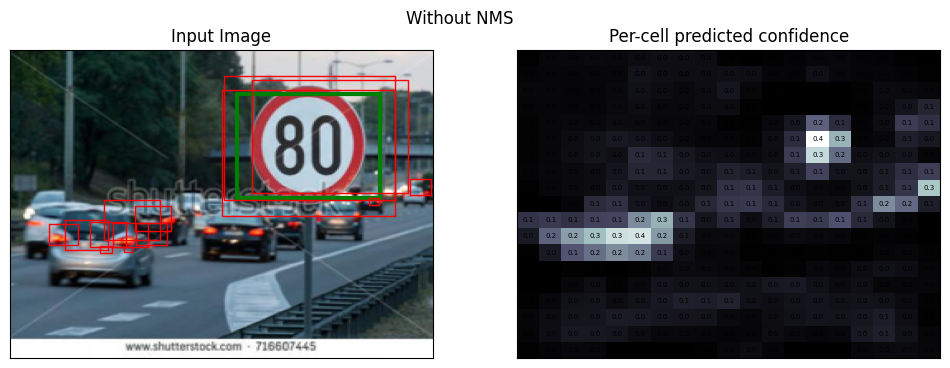

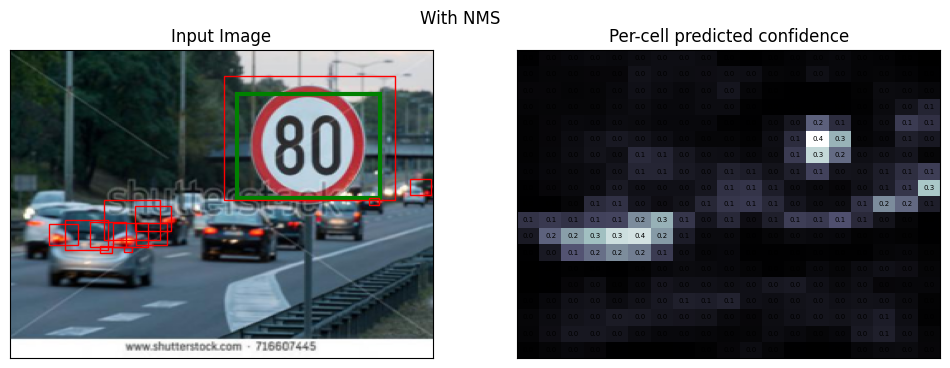

In [78]:
i = np.random.randint(0, len(test_dataset))
image, label = test_dataset[i]
prediction = model(image[None, ...].to(device))[0]

plot_image_bb(image, label, prediction, n_cells, confidence_threshold=0.2)
plt.suptitle("Without NMS")
plot_image_bb(image, label, prediction, n_cells, confidence_threshold=0.2, use_nms=True, iou_threshold=0.7)
plt.suptitle("With NMS")
plt.show()

#### Get Average Results over Test dataset

In [79]:
from tqdm import tqdm

def average_iou(true_rectangles, pred_rectangles):
    """
    Computes the average IoU value over bounding boxes.
    Uses a greedy approach: for each true bbox, take the predicted bbox with the highest IoU as it's assigned prediction.

    Note: in the original YOLO formulation each IoU is weighted by the corresponding predicted confidence.
    """
    avg_iou = 0
    for t_r in true_rectangles:
        max_iou = 0
        for p_r in pred_rectangles:
            iou = iou_boxes(t_r, p_r)
            max_iou = max(iou, max_iou)

        avg_iou += max_iou

    return avg_iou / len(true_rectangles)

def average_metrics(dataset, model, confidence_th, iou_th):
    """
    Compute average metrics over detection dataset.
    """
    avg_iou = 0
    n_boxes_detected = 0
    n_boxes = 0
    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]
        prediction = model(image[None, ...].to(device))[0]

        n_correct, n_total, true_rectangles, pred_rectangles = plot_image_bb(image, 
                                                                            label, 
                                                                            prediction, 
                                                                            n_cells, 
                                                                            confidence_threshold=confidence_th, 
                                                                            use_nms=True, 
                                                                            iou_threshold=iou_th,
                                                                            plot=False)
        avg_iou += average_iou(true_rectangles, pred_rectangles)
        
        n_boxes += n_total
        n_boxes_detected += n_correct

    print(f"Detection accuracy: {n_boxes_detected / n_boxes}; Average IoU: {avg_iou / len(dataset)} ;confidence_th={confidence_th} iou_th={iou_th}")

In [80]:
average_metrics(test_dataset, model, 0.1, 0.1)
average_metrics(test_dataset, model, 0.2, 0.1)
average_metrics(test_dataset, model, 0.3, 0.1)
average_metrics(test_dataset, model, 0.4, 0.1)
average_metrics(test_dataset, model, 0.5, 0.1)

100%|██████████| 173/173 [00:06<00:00, 25.89it/s]


Detection accuracy: 0.6559633027522935; Average IoU: 0.3337155282497406 ;confidence_th=0.1 iou_th=0.1


100%|██████████| 173/173 [00:05<00:00, 29.04it/s]


Detection accuracy: 0.3944954128440367; Average IoU: 0.26683613657951355 ;confidence_th=0.2 iou_th=0.1


100%|██████████| 173/173 [00:05<00:00, 31.04it/s]


Detection accuracy: 0.21559633027522937; Average IoU: 0.19301459193229675 ;confidence_th=0.3 iou_th=0.1


100%|██████████| 173/173 [00:05<00:00, 30.67it/s]


Detection accuracy: 0.03211009174311927; Average IoU: 0.04445318132638931 ;confidence_th=0.4 iou_th=0.1


100%|██████████| 173/173 [00:05<00:00, 29.79it/s]

Detection accuracy: 0.0; Average IoU: 0.0 ;confidence_th=0.5 iou_th=0.1


---
---
## Homework 🔬

Analyze the role of `l2_penalty` on the final performance. You should compare the `Detection Accuracy` and `Average IoU` for **at least 3** different values of `confidence_th` and **at least 3** different values of `iou_th`.

In the end, you should have a table looking like this:

<table style="margin: 0px auto;">
<thead>
<tr>
<th>l2_penalty</th>
<th>Confidence Threshold</th>
<th>IoU Threshold</th>
<th>Detection Accuracy</th>
<th>Average IoU</th>
</tr></thead>
<tbody>
<tr>
<td rowspan="3">x</td>
<td>ct_1</td>
<td>it_1</td>
<td></td>
<td></td>
</tr>
<tr>
<td>ct_2</td>
<td>it_2</td>
<td></td>
<td></td>
</tr>
<tr>
<td>ct_3</td>
<td>it_3</td>
<td></td>
<td></td>
</tr>
<tr>
<td rowspan="3">y</td>
<td>ct_1</td>
<td>it_1</td>
<td></td>
<td></td>
</tr>
<tr>
<td>ct_2</td>
<td>it_2</td>
<td></td>
<td></td>
</tr>
<tr>
<td>ct_3</td>
<td>it_3</td>
<td></td>
<td></td>
</tr>
<tr>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</tbody>
</table>
 
❗ You could (usually should) take a look at the `Detection Precision`, i.e. out of the detected objects how many were actually traffic signs. `Detection Accuracy` may give you non-representative results, since setting a lower `confidence_th` will yield in accuracies close to $100\%$

❗ Be careful when increasing the value of `l2_penalty` too much - loss could become too high (due to increased attention for weight values) and you may need more epochs to converge. As a rule of thumb, you should strive to get a `test_loss` $\leq 0.08$ for your models, to get decent performance.

❗ To save some time, you can use previous checkpoints from your experiments as a starting point and just change the `l2_penalty` parameter (i.e. define a new optimizer and re-train).

---
---